# TREINAMENTO REDE ViT V1.1ViT.1CLe

**Rede:** ViT pre-trained

**Dataset:** Cleaned Localized Equilibrado

> Epochs = 70

> Batch = 32

> Target = (224, 224)

> SEED = 10

> DATA AUGMENTATION? Não

> CLUSTERIZAÇÃO? Não

In [1]:
!nvidia-smi

Tue Oct  1 12:29:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
os.environ['TF_DISABLE_JIT'] = '1'

In [3]:
!jupyter notebook --NotebookApp.iopub_msg_rate_limit=1.0e10

[I 12:29:13.202 NotebookApp] [nb_conda_kernels] enabled, 1 kernels found
[I 12:29:13.267 NotebookApp] Writing notebook server cookie secret to /root/.local/share/jupyter/runtime/notebook_cookie_secret

  _   _          _      _
 | | | |_ __  __| |__ _| |_ ___
 | |_| | '_ \/ _` / _` |  _/ -_)
  \___/| .__/\__,_\__,_|\__\___|
       |_|
                       
Read the migration plan to Notebook 7 to learn about the new features and the actions to take if you are using extensions.

https://jupyter-notebook.readthedocs.io/en/latest/migrate_to_notebook7.html

Please note that updating to Notebook 7 might break some of your extensions.

[I 12:29:13.596 NotebookApp] Registered dataproc_jupyter_plugin server extension
jupyter_http_over_ws extension initialized. Listening on /http_over_websocket
[I 12:29:13.996 NotebookApp] Skipped non-installed server(s): bash-language-server, dockerfile-language-server-nodejs, javascript-typescript-langserver, jedi-language-server, julia-language-server, pyr

## Bibliotecas e Constantes

In [4]:
#!pip install tensorflow[and-cuda]

In [5]:
#------------------------------------------------------------------------------
# BIBLIOTECAS

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys
import random

# BIBLIOTECAS DEEP LEARNING
import datetime
import tensorflow as tf
import tensorflow.keras.layers as layers
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing import image

#------------------------------------------------------------------------------
# CONSTANTES

DATASET_TYPE = ['cleaned', 'selected-localized', 'cleaned-localized']
DATASET_TYPE = DATASET_TYPE[2] # Dataset utilizado no treinamento

DATASET_COMPLETO = False

CNN_MODEL = 'vit' # Rede utilizada no treinamento

SEED = 10
np.random.seed(SEED) # semente geradora dos numeros aleatorios
random.seed(SEED)
tf.random.set_seed(SEED)

N_FOLDS = 5
N_EPOCHS = 70
BATCH_SIZE = 32
SIZE = 224
TARGET_SIZE = (SIZE, SIZE)

VERSION = '1.1ViT.2CLe'

2024-10-01 12:29:20.055774: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 12:29:20.055902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 12:29:20.173947: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Diretórios e Carregamentos de Dados

In [6]:
# Criando pasta de resultados
if not os.path.exists(f'{DATASET_TYPE}'):
    os.mkdir(f'{DATASET_TYPE}')

In [7]:
#------------------------------------------------------------------------------
# DIRETÓRIOS DOS DATASETS

DATASET_PATH = '/kaggle/input/myocardit-dataset-cleaned-localized'
RESULTS_PATH = f'/kaggle/working/{DATASET_TYPE}'

NORMAL_PATH = DATASET_PATH + '/Normal/'
SICK_PATH = DATASET_PATH + '/Sick/'

# Diretorios de cada Individuo:
normal_datasets = [f'{NORMAL_PATH}Individuo_{i:02}/' for i in range(1, 17)]
sick_datasets = [f'{SICK_PATH}Individuo_{i:02}/' for i in range(17, 48)]

print(normal_datasets)
print(sick_datasets)

NORMAL_SPLITS = [[2, 10, 14],
                 [4, 7, 13],
                 [6, 8, 11, 15, 16],
                 [1, 5],
                 [3, 3, 12]]

#Grupo 1: ['Individuo_2', 'Individuo_10', 'Individuo_14'], Soma: 1334.0
#Grupo 2: ['Individuo_4', 'Individuo_7', 'Individuo_13'], Soma: 1342.0
#Grupo 3: ['Individuo_6', 'Individuo_8', 'Individuo_11', 'Individuo_15', 'Individuo_16'], Soma: 1339.0
#Grupo 4: ['Individuo_1', 'Individuo_5'], Soma: 1321.0
#Grupo 5: ['Individuo_3', 'Individuo_9', 'Individuo_12'], Soma: 1339.0
#Soma total: 6675.0, Média por grupo: 1335.0

if DATASET_COMPLETO == True:
    SICK_SPLITS = [[18, 29, 32, 35, 41, 43, 45],
                   [19, 20, 27, 34, 42],
                   [17, 23, 30, 33, 38],
                   [22, 28, 31, 36, 37, 40, 44, 47],
                   [21, 24, 25, 25, 39, 46]]
    
#Grupo 1: ['Individuo_18', 'Individuo_29', 'Individuo_32', 'Individuo_35', 'Individuo_41', 'Individuo_43', 'Individuo_45'], Soma: 2637.0
#Grupo 2: ['Individuo_19', 'Individuo_20', 'Individuo_27', 'Individuo_34', 'Individuo_42'], Soma: 2636.0
#Grupo 3: ['Individuo_17', 'Individuo_23', 'Individuo_30', 'Individuo_33', 'Individuo_38'], Soma: 2637.0
#Grupo 4: ['Individuo_22', 'Individuo_28', 'Individuo_31', 'Individuo_36', 'Individuo_37', 'Individuo_40', 'Individuo_44', 'Individuo_47'], Soma: 2637.0
#Grupo 5: ['Individuo_21', 'Individuo_24', 'Individuo_25', 'Individuo_26', 'Individuo_39', 'Individuo_46'], Soma: 2636.0
#Soma total: 13183.0, Média por grupo: 2636.6
    
else:
    SICK_SPLITS = [[24, 33, 35, 41],
                   [25, 32, 36, 42],
                   [26, 31, 37, 43],
                   [27, 30, 39, 45],
                   [28, 29, 38, 44]]
    
#Grupo 1: ['Individuo_24', 'Individuo_33', 'Individuo_35', 'Individuo_41'], Soma: 1348.0
#Grupo 2: ['Individuo_25', 'Individuo_32', 'Individuo_36', 'Individuo_42'], Soma: 1369.0
#Grupo 3: ['Individuo_26', 'Individuo_31', 'Individuo_37', 'Individuo_43'], Soma: 1401.0
#Grupo 4: ['Individuo_27', 'Individuo_30', 'Individuo_39', 'Individuo_45'], Soma: 1430.0
#Grupo 5: ['Individuo_28', 'Individuo_29', 'Individuo_38', 'Individuo_44'], Soma: 1429.0
#Média das somas dos grupos: 1395.40

normal_splits = [[],[],[],[],[]]
sick_splits = [[],[],[],[],[]]

for split in range(N_FOLDS):
    normal_splits[split].extend(normal_datasets[i-1] for i in NORMAL_SPLITS[split])
    sick_splits[split].extend(sick_datasets[i-17] for i in SICK_SPLITS[split])

['/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_01/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_02/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_03/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_04/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_05/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_06/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_07/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_08/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_09/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_10/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_11/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_12/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_13/', '/kaggle/input/myocardit-dataset-clea

In [8]:
#------------------------------------------------------------------------------
# CARREGAMENTO DE DADOS COM SEPARAÇÃO DE INDIVIDUOS

print('\nIniciando carregamento e processamento das imagens..............!')

def carregar_imagens(diretorio):
    global num_imagens
    imagens = []
    for pasta_atual, subpastas, arquivos in os.walk(diretorio):
        for arquivo in arquivos:
            if arquivo.endswith(('.jpg', '.jpeg', '.png')):
                caminho = os.path.join(pasta_atual, arquivo)
                
                img = Image.open(caminho)
                img = img.resize(TARGET_SIZE)
                img = img.convert('RGB')  # Mude para RGB
                img_array = np.array(img)
                imagens.append(img_array)
                
                num_imagens += 1
                sys.stdout.write("\rNumero de imagens carregados: %i" % num_imagens)
                sys.stdout.flush()
                
    return imagens

num_imagens = 0

print('\nPacientes normais:')
normal_groups = []
for diretorios in normal_splits:
    imagens = []
    for individuos in diretorios:
        imagens.extend(carregar_imagens(individuos))
    normal_groups.append(imagens)

num_imagens = 0

print('\n\nPacientes doentes:')
sick_groups = []
for diretorios in sick_splits:
    imagens = []
    for individuos in diretorios:
        imagens.extend(carregar_imagens(individuos))
    sick_groups.append(imagens)

# DATASETS SEPRADAOS EM 5 PARA VALIDAÇÃO CRUZADA    
x_data = [[],[],[],[],[]]
y_data = [[],[],[],[],[]]

print('\n\nNumero de imagens por split:')
for i in range(N_FOLDS):
    x_data[i].extend(path for path in normal_groups[i])
    y_data[i].extend([1, 0] for path in normal_groups[i])
    x_data[i].extend(path for path in sick_groups[i])
    y_data[i].extend([0, 1] for path in sick_groups[i])
    print(f'Split {i+1}: {len(x_data[i])} imagens ({len(normal_groups[i])} saudáveis e {len(sick_groups[i])} doentes).')


Iniciando carregamento e processamento das imagens..............!

Pacientes normais:
Numero de imagens carregados: 7009

Pacientes doentes:
Numero de imagens carregados: 1462

Numero de imagens por split:
Split 1: 1575 imagens (1334 saudáveis e 241 doentes).
Split 2: 1541 imagens (1342 saudáveis e 199 doentes).
Split 3: 1649 imagens (1339 saudáveis e 310 doentes).
Split 4: 1676 imagens (1321 saudáveis e 355 doentes).
Split 5: 2030 imagens (1673 saudáveis e 357 doentes).


## Treinamento

In [9]:
import tensorflow_hub as hub

class TransformerModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(TransformerModel, self).__init__()
        self.vit_layer = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_b16_fe/1", trainable=False)
        self.dense_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.vit_layer(inputs)
        return self.dense_layer(x)

In [10]:
# Definição da função de pré-processamento
def preprocess_dataset(images):
    images = images.astype('float32') / 255.0  # Normalizando para [0, 1]
    return images

# SEPARAÇÃO DE DADOS E TREINAMENTO

lst_accuracy = []
lst_accuracy_v = []
lst_accuracy_train = []
lst_acc = []
lst_loss = []
lst_reports = []
lst_AUC = []
lst_matrix = []
lst_matrix_v = []
lst_matrix_train = []
lst_times = []
lst_history = []

# TREINAMENTO POR FOLDS

for fold in range(N_FOLDS):
    print(f'\n\nFOLD {fold + 1}:')
    
    # Carregamento dos dados de treinamento, validação e teste
    x_test = np.array(x_data[fold])
    y_test = np.array(y_data[fold])
    
    folds = [i for i in range(N_FOLDS) if i != fold]
    x_valid = np.array(x_data[folds[0]])
    y_valid = np.array(y_data[folds[0]])
    
    x_train, y_train = [], []
    for i in folds[1:]:
        x_train.extend(x_data[i])
        y_train.extend(y_data[i])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    # Chamando a função de pré-processamento
    x_train = preprocess_dataset(x_train)
    x_valid = preprocess_dataset(x_valid)
    x_test = preprocess_dataset(x_test)

    print(f'Numero de imagens no treinamento: {len(x_train)} imagens.')
    print(f'Numero de imagens na validação: {len(x_valid)} imagens.')
    print(f'Numero de imagens no teste: {len(x_test)} imagens.')

    #--------------------------------------------------------------------------
    # Arquitetura e compilação

    # Definindo o modelo com entrada de imagens 100x100x1 e 2 classes
    SIZE = 224
    model = TransformerModel(2)

    # Compilando o modelo
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Sumário do modelo
    model.summary()
    
    #--------------------------------------------------------------------------
    # Treinamento
    
    print('\nIniciando o treinamento.........................................!\n')

    calback = CSVLogger(RESULTS_PATH + f'/logger_fold{fold+1}.log')

    # Treinamento com augmentação
    start = datetime.datetime.now()

    history = model.fit(x_train, y_train,
                        epochs=N_EPOCHS,
                        validation_data=(x_valid, y_valid),
                        callbacks=[calback])

    end = datetime.datetime.now()
    training_time = end - start

    # Salvando o modelo
    model.save(RESULTS_PATH + f'/{DATASET_TYPE}-CNN-{fold+1}.keras')

    #--------------------------------------------------------------------------
    # Teste
    print("\nTestando imagens................................................!\n")
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(model.metrics_names)

    #--------------------------------------------------------------------------
    # ARMAZENAMENTO DOS INFORMACOES

    # Fazendo previsões
    predicts = model.predict(x_test)
    predicts = predicts.argmax(axis=1)

    # Obtendo os rótulos verdadeiros
    actuals=y_test.argmax(axis=1)

    # Calculando a curva ROC
    fpr, tpr, _ = roc_curve(actuals, predicts, pos_label=1)
    a = auc(fpr, tpr)

    # Gerando o relatório de classificação
    r = classification_report(actuals, predicts, zero_division=1)

    # Calculando a matriz de confusão
    c = confusion_matrix(actuals, predicts)
    accuracy = np.trace(c)/np.sum(c)
    
    # Validação
    # Fazendo previsões
    predicts_v = model.predict(x_valid)
    predicts_v = predicts_v.argmax(axis=1)

    # Obtendo os rótulos verdadeiros
    actuals_v=y_valid.argmax(axis=1)
    
    # Calculando a matriz de confusão
    c_v = confusion_matrix(actuals_v, predicts_v)
    accuracy_v = np.trace(c_v)/np.sum(c_v)
    
    # Treino
    # Fazendo previsões
    predicts_train = model.predict(x_train)
    predicts_train = predicts_train.argmax(axis=1)

    # Obtendo os rótulos verdadeiros
    actuals_train=y_train.argmax(axis=1)
    
    # Calculando a matriz de confusão
    c_train = confusion_matrix(actuals_train, predicts_train)
    accuracy_train = np.trace(c_train)/np.sum(c_train)

    lst_history.append(history)
    lst_times.append(training_time)
    lst_accuracy.append(accuracy)
    lst_acc.append(test_acc)
    lst_loss.append(test_loss)
    lst_AUC.append(a)
    lst_reports.append(r)
    lst_matrix.append(c)
    
    lst_accuracy_v.append(accuracy_v)
    lst_matrix_v.append(c_v)
    
    lst_accuracy_train.append(accuracy_train)
    lst_matrix_train.append(c_train)



FOLD 1:
Numero de imagens no treinamento: 5355 imagens.
Numero de imagens na validação: 1541 imagens.
Numero de imagens no teste: 1575 imagens.


Model: "transformer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento.........................................!

Epoch 1/70


I0000 00:00:1727785857.877661     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1727785857.906781     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7723 - loss: 0.5743

W0000 00:00:1727785920.308486     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1727785926.129357     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


168/168 ━━━━━━━━━━━━━━━━━━━━ 100s 532ms/step - accuracy: 0.7727 - loss: 0.5732 - val_accuracy: 0.7833 - val_loss: 0.4470
Epoch 2/70


W0000 00:00:1727785947.123268     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


168/168 ━━━━━━━━━━━━━━━━━━━━ 83s 494ms/step - accuracy: 0.9144 - loss: 0.2168 - val_accuracy: 0.7943 - val_loss: 0.4565
Epoch 3/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 83s 492ms/step - accuracy: 0.9411 - loss: 0.1630 - val_accuracy: 0.7872 - val_loss: 0.4768
Epoch 4/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 83s 492ms/step - accuracy: 0.9541 - loss: 0.1372 - val_accuracy: 0.7852 - val_loss: 0.4949
Epoch 5/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 82s 491ms/step - accuracy: 0.9610 - loss: 0.1212 - val_accuracy: 0.7813 - val_loss: 0.5103
Epoch 6/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 142s 494ms/step - accuracy: 0.9630 - loss: 0.1098 - val_accuracy: 0.7813 - val_loss: 0.5235
Epoch 7/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 82s 491ms/step - accuracy: 0.9666 - loss: 0.1010 - val_accuracy: 0.7800 - val_loss: 0.5349
Epoch 8/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 142s 492ms/step - accuracy: 0.9683 - loss: 0.0939 - val_accuracy: 0.7800 - val_loss: 0.5450
Epoch 9/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 82s 491ms/step - accuracy: 0.9712 - loss: 0.0879 - v

W0000 00:00:1727792376.721833     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


['loss', 'compile_metrics']
 1/50 ━━━━━━━━━━━━━━━━━━━━ 2:43 3s/step

W0000 00:00:1727792382.299414     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 440ms/step


W0000 00:00:1727792403.850098     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 437ms/step


W0000 00:00:1727792427.182392     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


168/168 ━━━━━━━━━━━━━━━━━━━━ 66s 397ms/step


W0000 00:00:1727792500.725995     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update




FOLD 2:
Numero de imagens no treinamento: 5355 imagens.
Numero de imagens na validação: 1575 imagens.
Numero de imagens no teste: 1541 imagens.


Model: "transformer_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento.........................................!

Epoch 1/70


W0000 00:00:1727792525.454649     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8209 - loss: 0.4430

W0000 00:00:1727792592.479455     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1727792598.625510     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


168/168 ━━━━━━━━━━━━━━━━━━━━ 102s 559ms/step - accuracy: 0.8211 - loss: 0.4423 - val_accuracy: 0.8832 - val_loss: 0.3241
Epoch 2/70


W0000 00:00:1727792619.183691     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


168/168 ━━━━━━━━━━━━━━━━━━━━ 83s 497ms/step - accuracy: 0.9213 - loss: 0.2016 - val_accuracy: 0.8717 - val_loss: 0.3453
Epoch 3/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 83s 493ms/step - accuracy: 0.9429 - loss: 0.1554 - val_accuracy: 0.8673 - val_loss: 0.3639
Epoch 4/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 142s 495ms/step - accuracy: 0.9531 - loss: 0.1318 - val_accuracy: 0.8546 - val_loss: 0.3817
Epoch 5/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 83s 493ms/step - accuracy: 0.9588 - loss: 0.1167 - val_accuracy: 0.8502 - val_loss: 0.3981
Epoch 6/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 83s 494ms/step - accuracy: 0.9644 - loss: 0.1058 - val_accuracy: 0.8463 - val_loss: 0.4126
Epoch 7/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 83s 493ms/step - accuracy: 0.9665 - loss: 0.0974 - val_accuracy: 0.8457 - val_loss: 0.4257
Epoch 8/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 83s 494ms/step - accuracy: 0.9707 - loss: 0.0906 - val_accuracy: 0.8438 - val_loss: 0.4379
Epoch 9/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 142s 495ms/step - accuracy: 0.9716 - loss: 0.0849 - v

W0000 00:00:1727799780.098046     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


['loss', 'compile_metrics']
 1/49 ━━━━━━━━━━━━━━━━━━━━ 2:31 3s/step

W0000 00:00:1727799785.481193     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 439ms/step


W0000 00:00:1727799806.546729     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 432ms/step


W0000 00:00:1727799830.088794     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


168/168 ━━━━━━━━━━━━━━━━━━━━ 66s 396ms/step


W0000 00:00:1727799903.677545     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update




FOLD 3:
Numero de imagens no treinamento: 5247 imagens.
Numero de imagens na validação: 1575 imagens.
Numero de imagens no teste: 1649 imagens.


Model: "transformer_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento.........................................!

Epoch 1/70


W0000 00:00:1727799927.871862     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/164 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8268 - loss: 0.4852

W0000 00:00:1727799994.444020     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8270 - loss: 0.4844

W0000 00:00:1727800001.042075     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


164/164 ━━━━━━━━━━━━━━━━━━━━ 102s 573ms/step - accuracy: 0.8273 - loss: 0.4836 - val_accuracy: 0.8083 - val_loss: 0.4831
Epoch 2/70


W0000 00:00:1727800021.555429     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


164/164 ━━━━━━━━━━━━━━━━━━━━ 82s 501ms/step - accuracy: 0.9247 - loss: 0.1959 - val_accuracy: 0.8203 - val_loss: 0.4369
Epoch 3/70
164/164 ━━━━━━━━━━━━━━━━━━━━ 82s 498ms/step - accuracy: 0.9428 - loss: 0.1535 - val_accuracy: 0.8229 - val_loss: 0.4237
Epoch 4/70
164/164 ━━━━━━━━━━━━━━━━━━━━ 82s 497ms/step - accuracy: 0.9512 - loss: 0.1316 - val_accuracy: 0.8292 - val_loss: 0.4213
Epoch 5/70
164/164 ━━━━━━━━━━━━━━━━━━━━ 82s 498ms/step - accuracy: 0.9564 - loss: 0.1175 - val_accuracy: 0.8330 - val_loss: 0.4239
Epoch 6/70
164/164 ━━━━━━━━━━━━━━━━━━━━ 82s 498ms/step - accuracy: 0.9605 - loss: 0.1073 - val_accuracy: 0.8298 - val_loss: 0.4292
Epoch 7/70
164/164 ━━━━━━━━━━━━━━━━━━━━ 82s 499ms/step - accuracy: 0.9647 - loss: 0.0994 - val_accuracy: 0.8273 - val_loss: 0.4366
Epoch 8/70
164/164 ━━━━━━━━━━━━━━━━━━━━ 82s 500ms/step - accuracy: 0.9645 - loss: 0.0931 - val_accuracy: 0.8260 - val_loss: 0.4456
Epoch 9/70
164/164 ━━━━━━━━━━━━━━━━━━━━ 82s 498ms/step - accuracy: 0.9681 - loss: 0.0877 - val

W0000 00:00:1727805685.741338     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


['loss', 'compile_metrics']
 1/52 ━━━━━━━━━━━━━━━━━━━━ 2:45 3s/step

W0000 00:00:1727805691.506071     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 442ms/step


W0000 00:00:1727805714.029044     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 430ms/step


W0000 00:00:1727805737.634021     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


164/164 ━━━━━━━━━━━━━━━━━━━━ 65s 398ms/step


W0000 00:00:1727805810.207860     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update




FOLD 4:
Numero de imagens no treinamento: 5220 imagens.
Numero de imagens na validação: 1575 imagens.
Numero de imagens no teste: 1676 imagens.


Model: "transformer_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento.........................................!

Epoch 1/70


W0000 00:00:1727805835.042743     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8157 - loss: 0.4793

W0000 00:00:1727805901.314868     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1727805906.939684     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


164/164 ━━━━━━━━━━━━━━━━━━━━ 101s 566ms/step - accuracy: 0.8159 - loss: 0.4786 - val_accuracy: 0.7714 - val_loss: 0.6395
Epoch 2/70


W0000 00:00:1727805927.655169     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


164/164 ━━━━━━━━━━━━━━━━━━━━ 128s 499ms/step - accuracy: 0.9052 - loss: 0.2361 - val_accuracy: 0.8000 - val_loss: 0.5773
Epoch 3/70
164/164 ━━━━━━━━━━━━━━━━━━━━ 81s 497ms/step - accuracy: 0.9302 - loss: 0.1846 - val_accuracy: 0.8051 - val_loss: 0.5541
Epoch 4/70
164/164 ━━━━━━━━━━━━━━━━━━━━ 81s 497ms/step - accuracy: 0.9406 - loss: 0.1600 - val_accuracy: 0.8133 - val_loss: 0.5423
Epoch 5/70
164/164 ━━━━━━━━━━━━━━━━━━━━ 81s 496ms/step - accuracy: 0.9508 - loss: 0.1437 - val_accuracy: 0.8152 - val_loss: 0.5353
Epoch 6/70
164/164 ━━━━━━━━━━━━━━━━━━━━ 81s 496ms/step - accuracy: 0.9519 - loss: 0.1316 - val_accuracy: 0.8184 - val_loss: 0.5312
Epoch 7/70
164/164 ━━━━━━━━━━━━━━━━━━━━ 82s 497ms/step - accuracy: 0.9579 - loss: 0.1222 - val_accuracy: 0.8178 - val_loss: 0.5292
Epoch 8/70
164/164 ━━━━━━━━━━━━━━━━━━━━ 81s 496ms/step - accuracy: 0.9610 - loss: 0.1145 - val_accuracy: 0.8165 - val_loss: 0.5287
Epoch 9/70
164/164 ━━━━━━━━━━━━━━━━━━━━ 82s 499ms/step - accuracy: 0.9639 - loss: 0.1081 - va

W0000 00:00:1727811633.039838     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


['loss', 'compile_metrics']
 1/53 ━━━━━━━━━━━━━━━━━━━━ 2:52 3s/step

W0000 00:00:1727811638.949804     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


53/53 ━━━━━━━━━━━━━━━━━━━━ 26s 440ms/step


W0000 00:00:1727811661.804698     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 433ms/step


W0000 00:00:1727811685.558811     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


164/164 ━━━━━━━━━━━━━━━━━━━━ 65s 398ms/step


W0000 00:00:1727811758.296535     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update




FOLD 5:
Numero de imagens no treinamento: 4866 imagens.
Numero de imagens na validação: 1575 imagens.
Numero de imagens no teste: 2030 imagens.


Model: "transformer_model_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento.........................................!

Epoch 1/70


W0000 00:00:1727811784.713390     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8291 - loss: 0.4486

W0000 00:00:1727811846.557759     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1727811852.146192     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 96s 577ms/step - accuracy: 0.8294 - loss: 0.4479 - val_accuracy: 0.8756 - val_loss: 0.3092
Epoch 2/70


W0000 00:00:1727811872.724259     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 77s 507ms/step - accuracy: 0.9136 - loss: 0.2156 - val_accuracy: 0.8673 - val_loss: 0.3063
Epoch 3/70
153/153 ━━━━━━━━━━━━━━━━━━━━ 77s 504ms/step - accuracy: 0.9344 - loss: 0.1620 - val_accuracy: 0.8571 - val_loss: 0.3260
Epoch 4/70
153/153 ━━━━━━━━━━━━━━━━━━━━ 77s 504ms/step - accuracy: 0.9476 - loss: 0.1367 - val_accuracy: 0.8489 - val_loss: 0.3445
Epoch 5/70
153/153 ━━━━━━━━━━━━━━━━━━━━ 77s 504ms/step - accuracy: 0.9584 - loss: 0.1198 - val_accuracy: 0.8444 - val_loss: 0.3609
Epoch 6/70
153/153 ━━━━━━━━━━━━━━━━━━━━ 77s 506ms/step - accuracy: 0.9634 - loss: 0.1077 - val_accuracy: 0.8413 - val_loss: 0.3752
Epoch 7/70
153/153 ━━━━━━━━━━━━━━━━━━━━ 77s 506ms/step - accuracy: 0.9672 - loss: 0.0983 - val_accuracy: 0.8381 - val_loss: 0.3882
Epoch 8/70
153/153 ━━━━━━━━━━━━━━━━━━━━ 82s 504ms/step - accuracy: 0.9704 - loss: 0.0908 - val_accuracy: 0.8368 - val_loss: 0.4004
Epoch 9/70
153/153 ━━━━━━━━━━━━━━━━━━━━ 82s 504ms/step - accuracy: 0.9737 - loss: 0.0847 - val

W0000 00:00:1727817329.713322     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


['loss', 'compile_metrics']
 1/64 ━━━━━━━━━━━━━━━━━━━━ 3:30 3s/step

W0000 00:00:1727817336.096466     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 429ms/step


W0000 00:00:1727817363.097249     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 425ms/step


W0000 00:00:1727817386.488021     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


153/153 ━━━━━━━━━━━━━━━━━━━━ 61s 399ms/step


W0000 00:00:1727817454.418097     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [11]:
#--------------------------------------------------------------------------
# SALVAMENTO DOS DADOS

print('\nSalvando informações da rede......................................!')

path = RESULTS_PATH + f'/results-v{VERSION}.txt'
    
matrix_total = np.sum(lst_matrix, axis=0)
accuracy_total = np.trace(matrix_total)/np.sum(matrix_total)

matrix_total_v = np.sum(lst_matrix_v, axis=0)
accuracy_total_v = np.trace(matrix_total_v)/np.sum(matrix_total_v)

matrix_total_train = np.sum(lst_matrix_train, axis=0)
accuracy_total_train = np.trace(matrix_total_train)/np.sum(matrix_total_train)
    
losses=[]
val_losses=[]
accuracies=[]
val_accuracies=[]

for item in lst_history:
    
    history=item.history
    loss=history['loss']
    accuracy=history['accuracy']
    
    val_loss=history['val_loss']
    val_accuracy=history['val_accuracy']
    
    losses.append(sum(loss)/len(loss))
    accuracies.append(sum(accuracy)/len(accuracy))
    
    val_losses.append(sum(val_loss)/len(val_loss))
    val_accuracies.append(sum(val_accuracy)/len(val_accuracy))

f1=open(path,'w')
f1.write(f'TREINAMENTO v{VERSION}\n')

f1.write('\nTest Accuracias: '+str(lst_acc)+'\nTest Losses: '+str(lst_loss))
f1.write('\n\nTest Accuracies Mean: '+str(np.mean(lst_acc)))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nValid Accuracies: '+str(val_accuracies)+'\nValid Losses: '+str(val_losses))
f1.write('\n\nValid Accuracies Mean: '+str(np.mean(val_accuracies)))

f1.write('\n\n__________________________________________________________\n')

f1.write('\nAccuracies from Confusion Matrix: '+str(lst_accuracy))

f1.write('\n\nTotal Confusion Matrix: \n'+str(matrix_total)+'\n\n')
f1.write('\nTotal Accuracie from Confusion Matrix: '+str(accuracy_total))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nTotal Confusion Matrix Valid: \n'+str(matrix_total_v)+'\n\n')
f1.write('\nTotal Accuracie from Confusion Matrix Valid: '+str(accuracy_total_v))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nTotal Confusion Matrix Train: \n'+str(matrix_total_train)+'\n\n')
f1.write('\nTotal Accuracie from Confusion Matrix Train: '+str(accuracy_total_train))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nMetrics for all Folds: \n\n')
for i in range(len(lst_reports)):
    f1.write(str(lst_reports[i]))
    f1.write('\n\nTraining Time: '+str(lst_times[i])+'\nAUC: '+str(lst_AUC[i]))
    f1.write('\n\nAcurácia: ' + str(lst_accuracy[i]))
    f1.write('\n\nMatriz de Confusao: \n'+str(lst_matrix[i])+'\n\n__________________________________________________________\n')
f1.close()


Salvando informações da rede......................................!


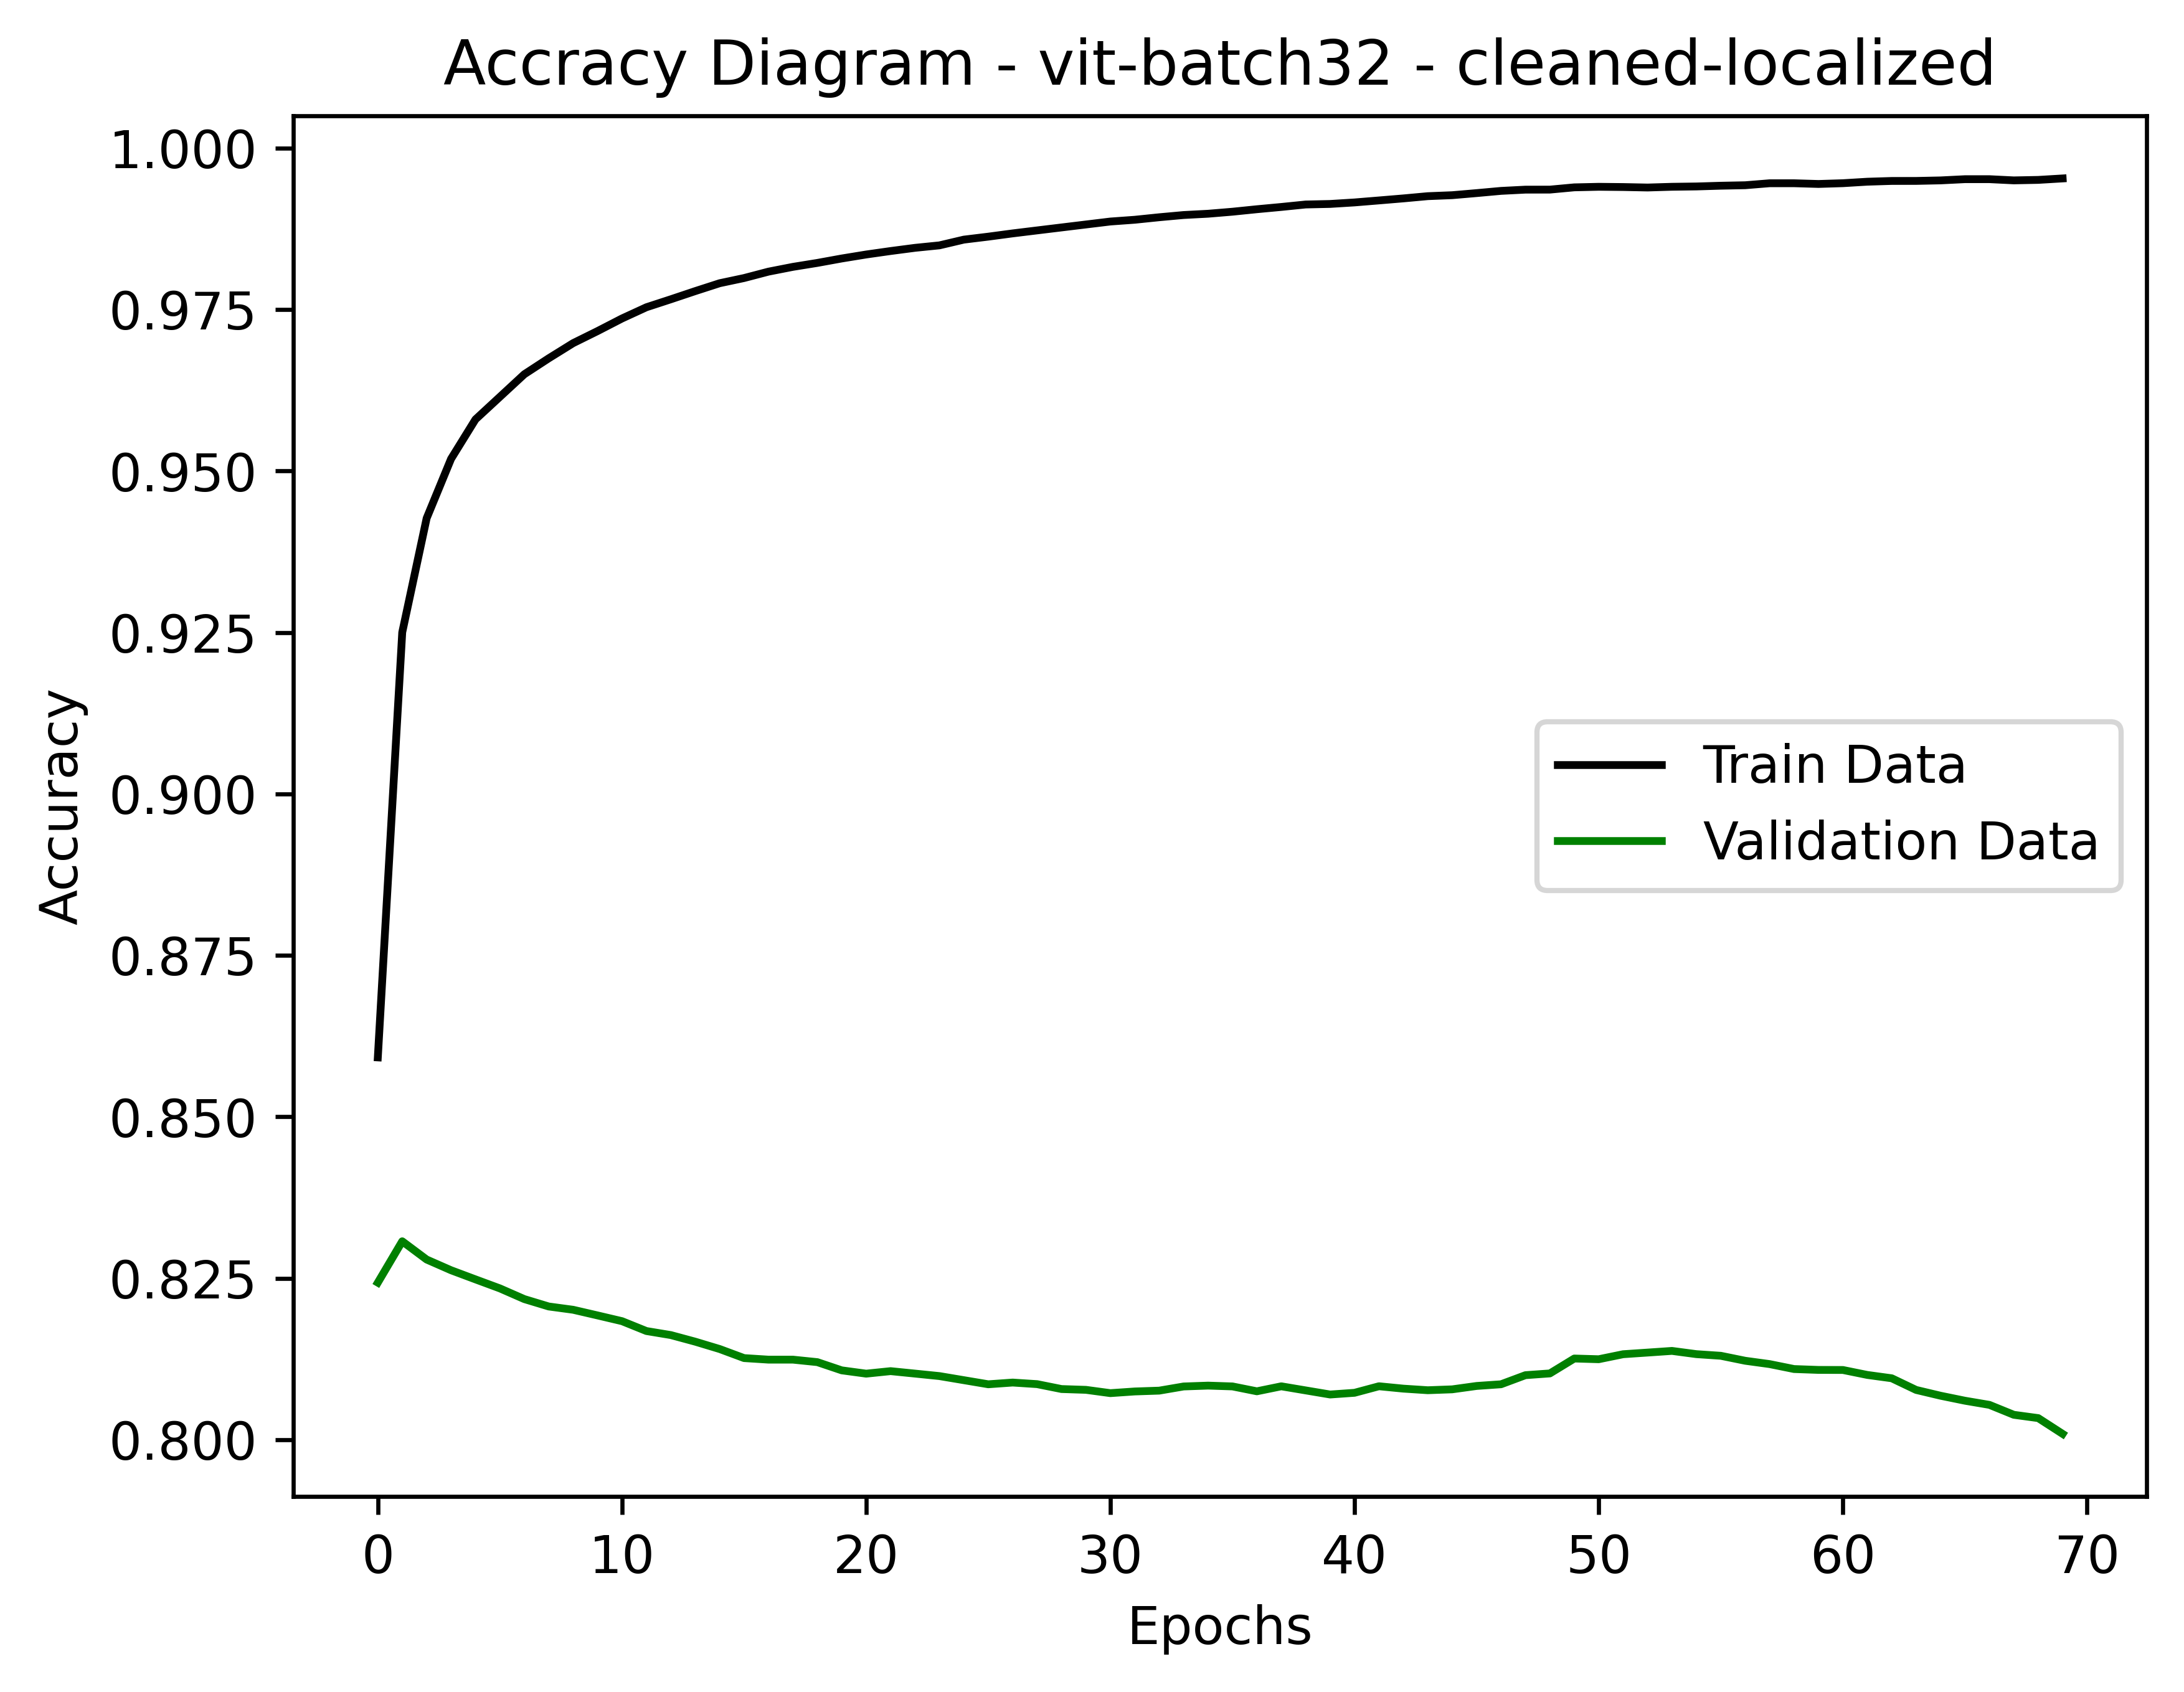

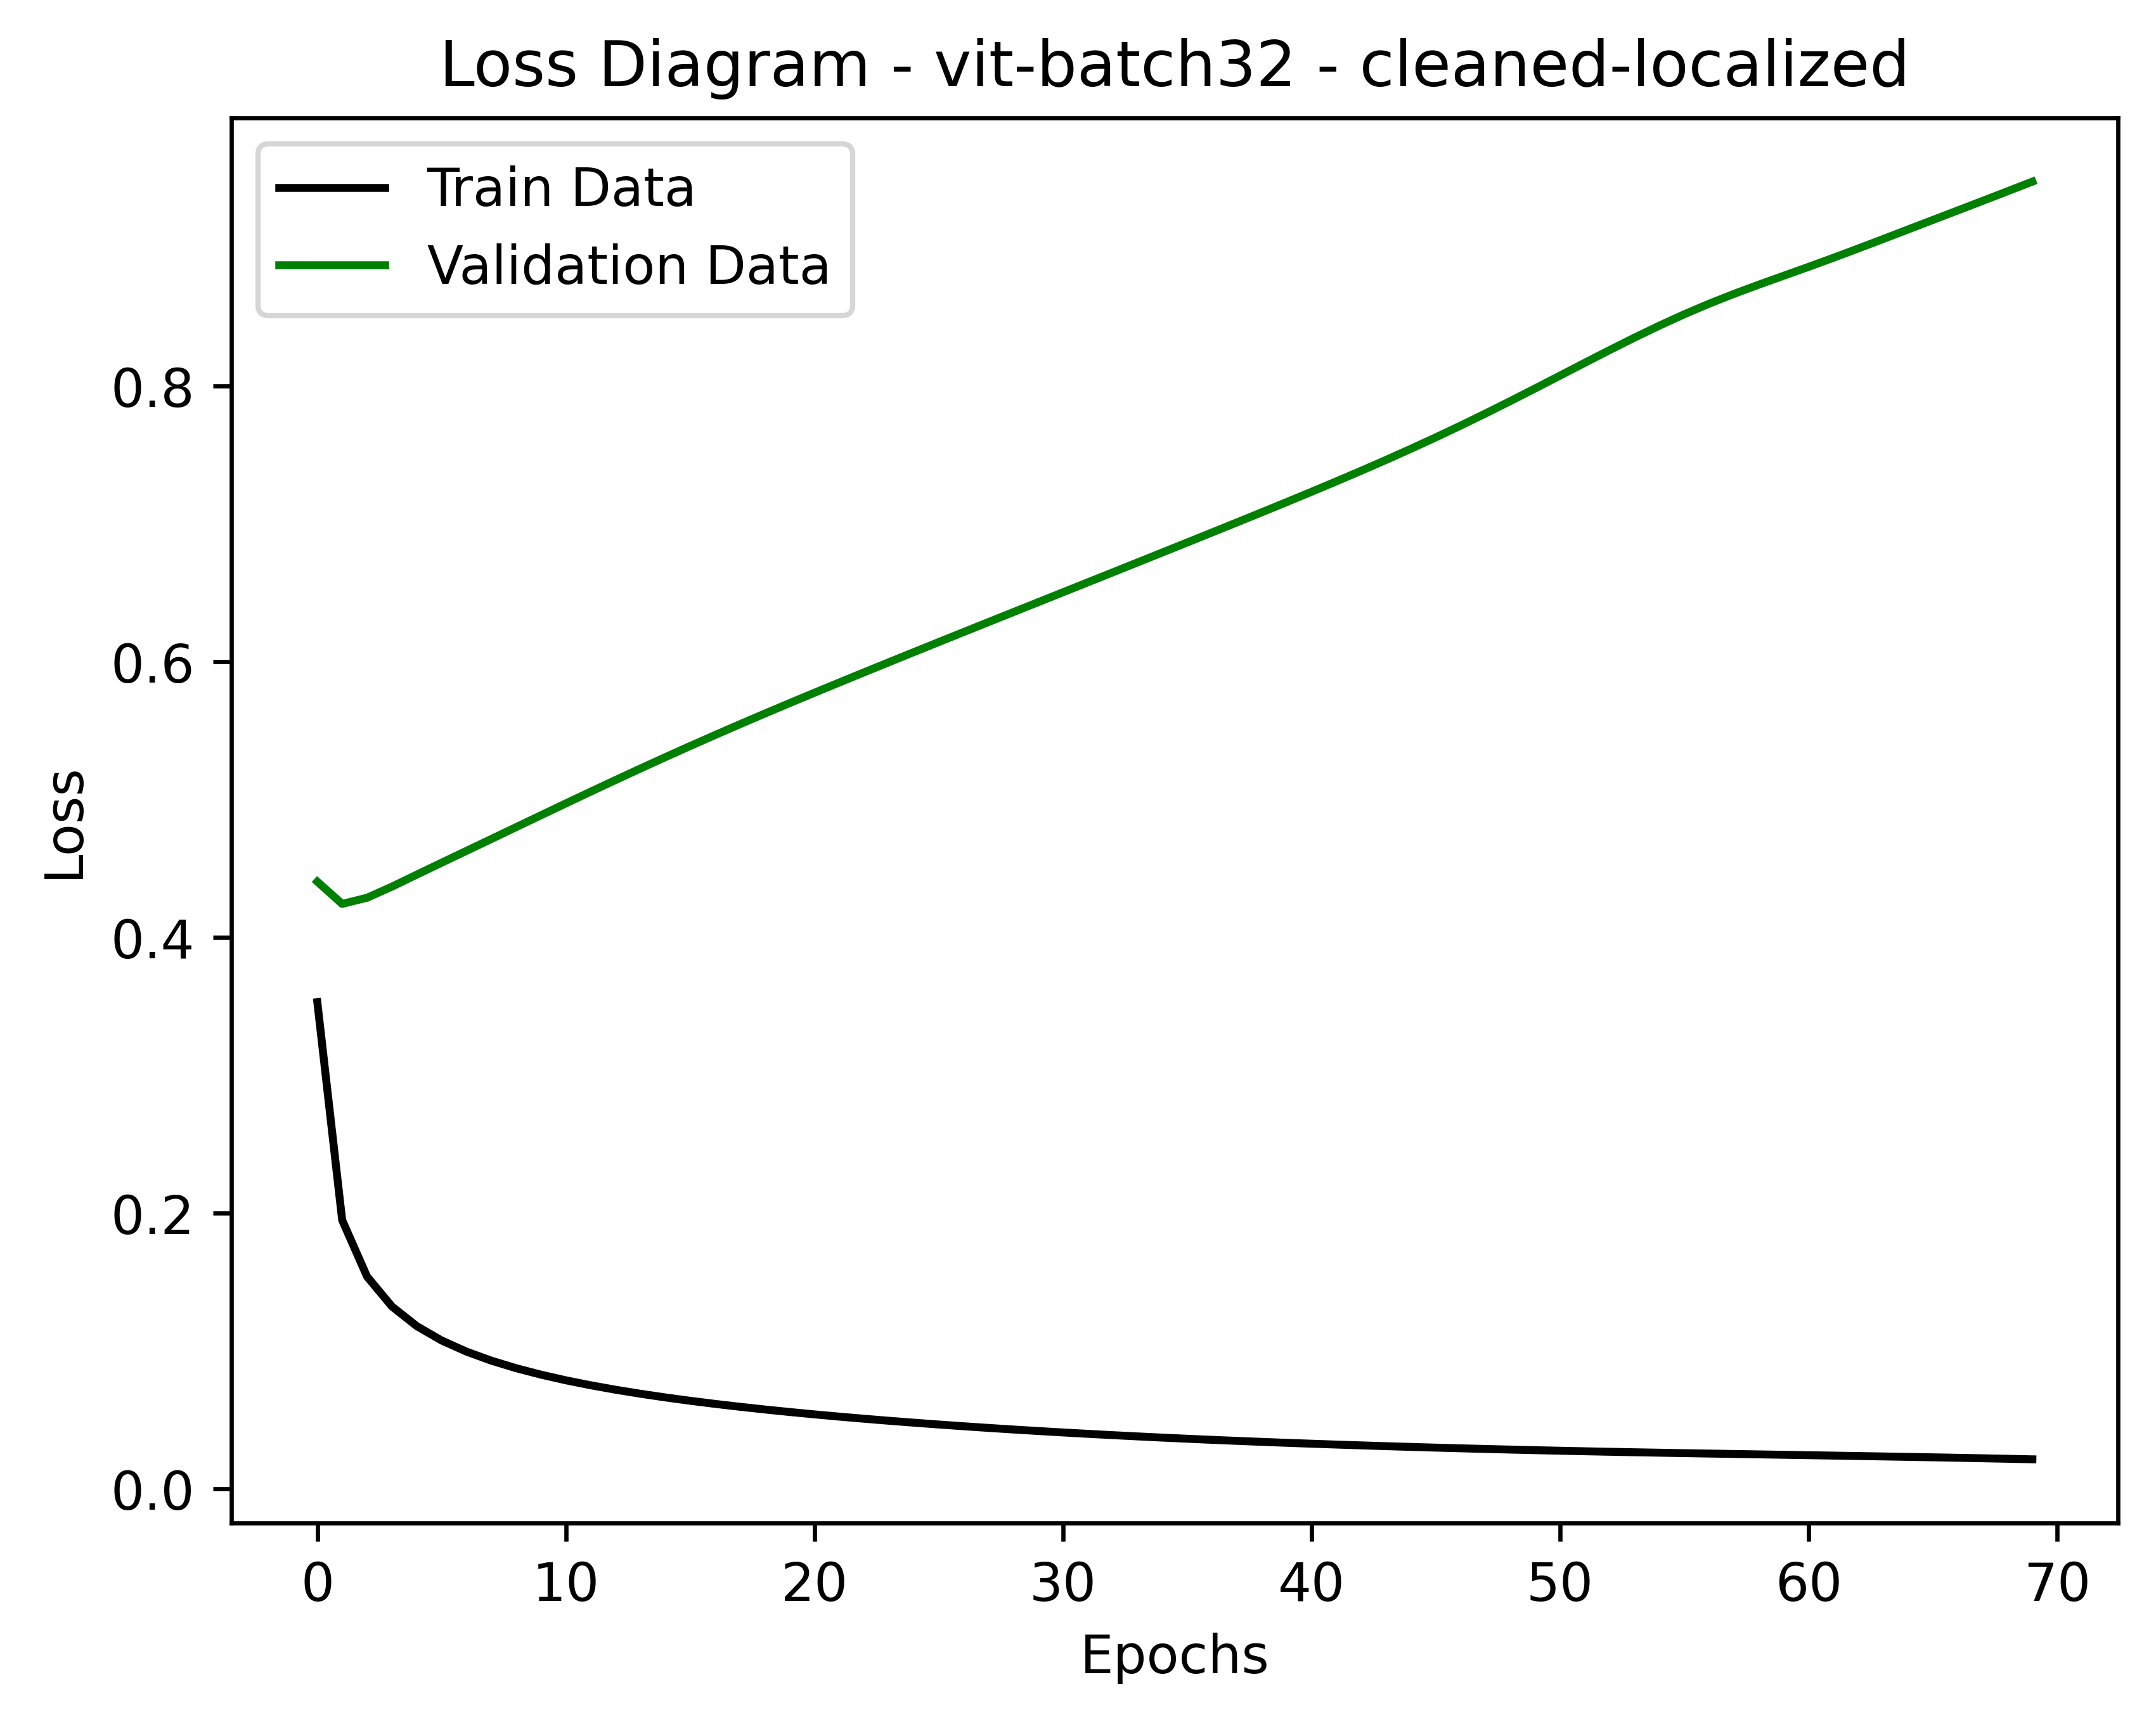

In [12]:
def NetPlot(net_histories,n_epch):
    import numpy as np
    import matplotlib.pyplot as plt

    losses=[]
    val_losses=[]
    accuracies=[]
    val_accuracies=[]

    for item in net_histories:

        history=item.history
        loss=history['loss']
        val_loss=history['val_loss']
        accuracy=history['accuracy']
        val_accuracy=history['val_accuracy']

        losses.append(loss)
        val_losses.append(val_loss)
        accuracies.append(accuracy)
        val_accuracies.append(val_accuracy)


    losses2=np.zeros((1,n_epch))
    val_losses2=np.zeros((1,n_epch))
    accuracies2=np.zeros((1,n_epch))
    val_accuracies2=np.zeros((1,n_epch))

    for i in losses:
        losses2+=i

    for i in val_losses:
        val_losses2+=i

    for i in accuracies:
        accuracies2+=i

    for i in val_accuracies:
        val_accuracies2+=i
        
    N_SPLITS = 5

    # 10 is number of folds
    losses2=(losses2/N_SPLITS).flatten()
    accuracies2=(accuracies2/N_SPLITS).flatten()
    val_losses2=(val_losses2/N_SPLITS).flatten()
    val_accuracies2=(val_accuracies2/N_SPLITS).flatten()
    
    # print('\nAccuracies: '+ str(accuracies2) +'\nLosses: '+ str(losses2))

    plt.figure('Accracy Diagram',dpi=600)
    plt.title(f'Accracy Diagram - {CNN_MODEL}-batch{BATCH_SIZE} - {DATASET_TYPE}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(accuracies2,color='black')
    plt.plot(val_accuracies2,color='green')
    plt.legend(['Train Data','Validation Data'])
    plt.savefig(f'{RESULTS_PATH}/Accuracy-Diagram-{CNN_MODEL}-batch{BATCH_SIZE}.jpg')

    plt.figure('Loss Diagram',dpi=600)
    plt.title(f'Loss Diagram - {CNN_MODEL}-batch{BATCH_SIZE} - {DATASET_TYPE}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(losses2,color='black')
    plt.plot(val_losses2,color='green')
    plt.legend(['Train Data','Validation Data'])
    plt.savefig(f'{RESULTS_PATH}/Loss-Diagram-{CNN_MODEL}-batch{BATCH_SIZE}.jpg')
    
NetPlot(lst_history,N_EPOCHS)

In [13]:
# Zipando pasta com resultados
import zipfile

def compactar_pasta(pasta, nome_arquivo_zip):
    with zipfile.ZipFile(nome_arquivo_zip, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        for root, _, files in os.walk(pasta):
            for arquivo in files:
                caminho_completo = os.path.join(root, arquivo)
                zip_file.write(caminho_completo, os.path.relpath(caminho_completo, pasta))

nome_arquivo_zip = f'{VERSION}-results.zip'
compactar_pasta(RESULTS_PATH, nome_arquivo_zip)